In [1]:
import ROOT
from ROOT import gROOT, TCanvas, TF1, TFile, TTree, gRandom, TH1F

from ROOT import RooRealVar, RooFormulaVar, RooVoigtian, RooChebychev, RooArgList, \
                 RooArgSet, RooAddPdf, RooDataSet, RooCategory, RooSimultaneous, \
                 RooBreitWigner, RooCBShape, RooFFTConvPdf, RooGaussian,RooExponential, \
                 RooBinning, kRed, kBlue, kDotted,TString,RooAbsData, RooPlot, TCut, RooAbsData, RooFit , RooStats               

In [2]:
import sys
sys.path.append('/home/chasenberg/repos/')
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os, sys, time, random
import ROOT 
from ROOT import TTree, TFile

# from root_numpy import root2array, rec2array, array2root

import pandas as pd
import numpy as np
import scipy 
import root_pandas as rp
import root_numpy as ry 

import pandas.core.common as com
from pandas.core.index import Index
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

from tqdm import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

sys.path.append('/home/chasenberg/repos/')
sys.path.append('/home/chasenberg/repos/dopy')
from dopy import * 
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations
from dopy.dolearn.sklearn_utils import plot_feature_importances, plot_classifier_output, classify_unseen_data
#from dopy.sklearn_utils import plot_bdt_vars
from dopy.doplot.plotting import Plotter, Plot
from dopy.doanalysis.df_utils import add_min_max, add_eta 

Declare data directories and read files
--------------------------------------

In [4]:
#directories and files 
mc_dir = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/'
mc_file= 'Bd2JpsiKS_random.root'
mc_dir = os.path.join(mc_dir, mc_file)
data_dir = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/'
data_file= 'Bd2JpsiKS_bestPV_sw.root'
data_dir = os.path.join(data_dir, data_file)

In [5]:
#Treename and cut for data
tree_data = 'Bd2JpsiKS'
cut_string_data = 'B0_FitDaughtersConst_M_flat<5450&B0_FitDaughtersConst_M_flat>5200'
#criteria and information for read in mc
cut_string_mc = 'B0_FitDaughtersConst_M_flat<5450&B0_FitDaughtersConst_M_flat>5200'
tree_mc = 'Bd2JpsiKS'

Load data from ROOT files
-------------------------------------------------------

In [6]:
signal_dataframe_wrongPV  = rp.read_root(mc_dir,key=tree_mc,where=cut_string_mc, flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [7]:
real_dataframe_wrongPV = rp.read_root(data_dir,key=tree_data,where=cut_string_data, flatten=False)
real_dataframe_wrongPV = real_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
real_dataframe_wrongPV = real_dataframe_wrongPV.dropna()
#real_dataframe_wrongPV = pd.concat([real_dataframe_wrongPV_2015])'''

## Plot control variable "pz_pull"


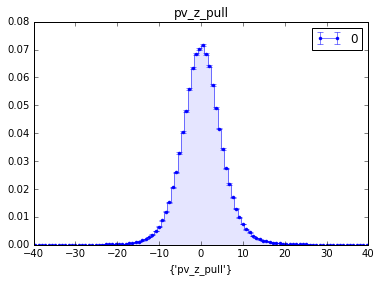

In [11]:
plot_var = ['pv_z_pull']
plot_names = plot_var

plotter = Plotter('/home/chasenberg/plots/wrong_pv/')
plotter.create_plots(signal_dataframe_wrongPV, plot_var)
plotter['pv_z_pull'].set_range(-40,40)#-5000,2000
#plotter['pv_z_pull'].set_log_y()
plotter.plot()

In [15]:
#Rescale Delta_tau
signal_dataframe_wrongPV['pv_z_pull_rescaled'] = signal_dataframe_wrongPV['pv_z_pull'] / np.linalg.norm(signal_dataframe_wrongPV['pv_z_pull'])
signal_dataframe_wrongPV['Delta_TAU_rescaled'] = 1000 * signal_dataframe_wrongPV['Delta_TAU'] / np.linalg.norm(signal_dataframe_wrongPV['Delta_TAU'])


In [ ]:
import numpy as np
from sklearn.preprocessing import normalize

x = np.random.rand(1000)*10
norm1 = x / np.linalg.norm(x)
norm2 = normalize(x[:,np.newaxis], axis=0).ravel()
print( np.all(norm1 == norm2))
print(norm1)

## Plot correlation of pv_z_pull and delta_tau

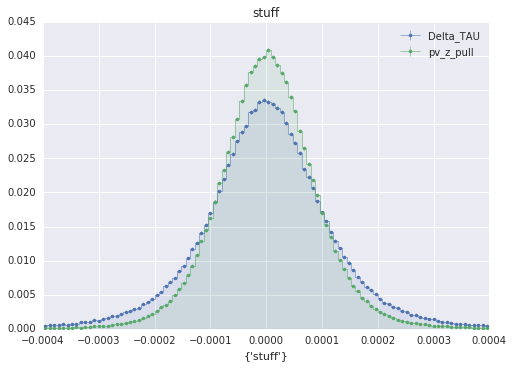

In [16]:
plot_var = ['stuff']
plot_names = plot_var

test1 = pd.DataFrame()
test2 = pd.DataFrame()
test1['stuff'] = signal_dataframe_wrongPV['Delta_TAU_rescaled']
test2['stuff'] = signal_dataframe_wrongPV['pv_z_pull_rescaled']
df = [test1,test2]
plotter = Plotter('/home/chasenberg/plots/wrong_pv/')
plotter.create_plots([test1,test2], plot_var,component_labels=['Delta_TAU','pv_z_pull'])
plotter['stuff'].set_range(-0.0004,0.0004)#-5000,2000
#plotter['pv_z_pull'].set_log_y()
plotter.plot()

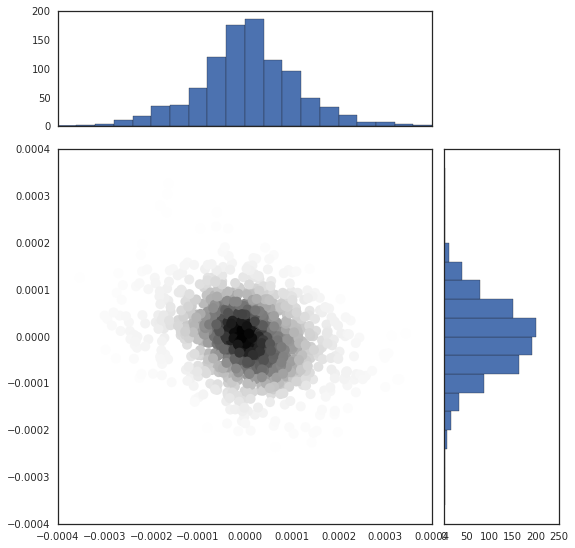

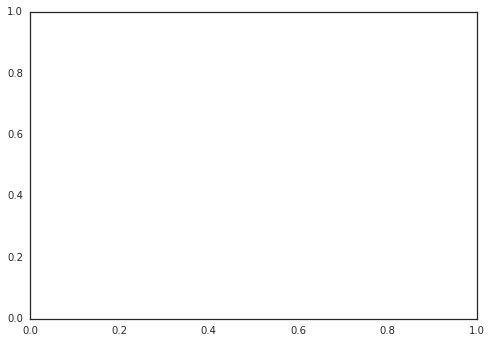

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.ticker import NullFormatter
import seaborn as sns

test = signal_dataframe_wrongPV.query('abs(Delta_TAU_rescaled)<0.0004&abs(pv_z_pull_rescaled)<0.0004').sample(1000)
# the random data
x =  pd.Series(test['Delta_TAU_rescaled'], name="\sigma_t")
y = pd.Series(test['pv_z_pull_rescaled'], name="pv_z") 

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.02, 0.65
bottom, height = 0.0002, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
axScatter.scatter(x, y, c=z, s=100, edgecolor='')
#sns.kdeplot(x, y, shade=True,cbar='coolwarm')

# now determine nice limits by hand:
binwidth = 0.00004

xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((-lim, lim))
axScatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins)
axHisty.hist(y, bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()

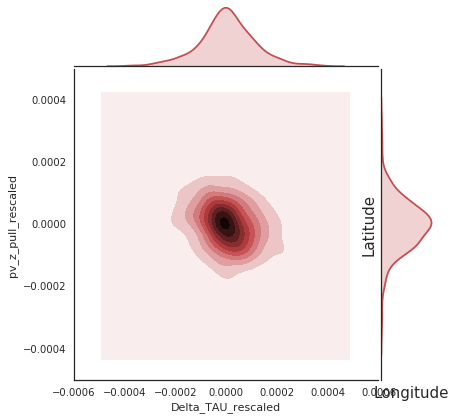

In [58]:
import seaborn as sns; sns.set_style('white')


#fig = plt.figure(1)

g = sns.jointplot(x='Delta_TAU_rescaled', y='pv_z_pull_rescaled', ylabel='PDF' ,data=test,stat_func=None,space=0.05, kind="kde", color="r")
#plt.set(xlabel=r'$e(t_0)$ [s]', ylabel='PDF')
#plt.xlabel(r'$e(t_0)$', fontsize=15)
plt.rc("legend", fontsize=15)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
#fig.gca().set(xlabel=r'$e(t_0)$ [s]', ylabel='PDF')

Declare bdt features and correlation matrix  
---------------------------------------------------------------------------------

In [ ]:
bdt_features = [  
       'B0_FitPVConst_IPCHI2_flat', 
       'B0_FitPVConst_chi2_flat',
       'B0_FitPVConst_MinIPCHI2anyPV_flat',
       #'B0_FitPVConst_J_psi_1S_MinIPCHI2anyPV_flat',
       'B0_FitPVConst_J_psi_1S_IPCHI2_flat',
       #'B0_FitPVConst_KS0_IPCHI2_flat',
       #'B0_FitPVConst_KS0_MinIPCHI2anyPV_flat',
       'B0_FitDaughtersConst_KS0_IP_flat',
       'muminus_MINIPCHI2',
       'muplus_MINIPCHI2', 
       'B0_FitPVConst_PV_Z_flat',  
      # 'B0_FitPVConst_Z_flat',
       'B0_FitDaughtersConst_J_psi_1S_min_PT'
]

In [ ]:
plt.figure(figsize=(12,8))
plot_correlations(signal_dataframe_wrongPV[bdt_features], annot=True, fmt='.2f')
plt.savefig('/home/chasenberg/plots/wrong_pv/correlation_data.png')
plt.show()
plt.figure(figsize=(12,8))
'''plot_correlations(signal_dataframe_wrongPV[bdt_features], annot=True, fmt='.2f')
plt.savefig('/home/chasenberg/plots/wrong_pv/correlation_mc.png')
plt.show()
print('Done!')'''

Plot sWeighted BDT variables against MC
----------------------------------------------------------------------------------

In [ ]:
variables = real_dataframe_wrongPV.columns.tolist().remove('signal_sw')

In [ ]:
real_dataframe_wrongPV.columns

## sWeighted data against mc

In [ ]:
for feature in bdt_features:
    print(feature)

In [ ]:
#Check bdt-variables 
mc_weight = np.ones(signal_dataframe_wrongPV.shape[0])
signal_dataframe_wrongPV['mc_weight'] = mc_weight

for feature in bdt_features:
    plotter = Plotter('/home/chasenberg/plots/wrong_pv/mc_agreement/')
    plotter.create_plots([real_dataframe_wrongPV,signal_dataframe_wrongPV], bdt_features, weightvars=['signal_sw','mc_weight']
    ,component_labels=['sWeighted data','Signal-MC'])
    plotter[feature].set_range(0,real_dataframe_wrongPV[feature].quantile(0.95))
    #plotter[feature].set_range(0,20)
    plotter.plot()

Train GradienBoost classifier
====================================================================

In [ ]:
correct_pvs = signal_dataframe_wrongPV.query('abs(pv_z_pull)<20')
incorrect_pvs = signal_dataframe_wrongPV.query('abs(pv_z_pull)>20')
flags = np.array([1]*len(correct_pvs)+[0]*len(incorrect_pvs))
dataframe = pd.concat([correct_pvs,incorrect_pvs])

In [ ]:
correct_pvs.shape, incorrect_pvs.shape,dataframe.shape

In [ ]:
#Apply Track Type cuts piminus_TRACK_Type

In [ ]:
train_dataframe, test_dataframe, train_flags, test_flags = train_test_split(
                                                            dataframe[bdt_features], flags, test_size=0.5, random_state=42)
classifier = GradientBoostingClassifier(max_depth=3, verbose=1,n_estimators=200,learning_rate=0.03)
classifier.fit(train_dataframe, train_flags)

In [ ]:
dataframe.shape

Classifier performance
-----------------------

In [ ]:
classifier.score(test_dataframe, test_flags)

In [ ]:
importances = classifier.feature_importances_
print("Features sorted by their score:" )
importances_sorted = sorted(zip(importances, dataframe.columns), reverse=True)
for val,name in importances_sorted:
    print('{}: {:.4f}'.format(name, val))

In [ ]:
#Plot feature importances 
plot_feature_importances(classifier,dataframe[bdt_features])
plt.savefig('/home/chasenberg/plots/wrong_pv/feature_importance.png', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(12,10))
plot_classifier_output(classifier, train_dataframe, train_flags, test_dataframe, test_flags, title='Ausgabe des BDT',bins=50)
plt.savefig('/home/chasenberg/plots/wrong_pv/overtraining.png')
plt.show()


In [ ]:
plot_roc_curve(classifier, test_dataframe, test_flags)
plt.savefig('/home/chasenberg/plots/wrong_pv/roc_curve.png')




Classify unseen Data
============================================

In [ ]:
#apply classifier to data and MC
classify_unseen_data([classifier], dataframe, bdt_features, 'BDTresponse_wrongPV')

Check efficiencies of classifier cuts
-------------------------------

In [ ]:
cut = 'BDTresponse_wrongPV>4'
efficiency = dataframe.query(cut).shape[0] / dataframe.shape[0]
print('The efficiency of the cut is:')
print(efficiency,dataframe.shape[0])
#compare to best PV selection
efficiency = dataframe.query('idxPV==0').shape[0] / dataframe.shape[0]
print('The efficiency of the bestPV selection is:')
print(efficiency,dataframe.shape[0])



In [ ]:
dataframe.query(cut).to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/Bd2JpsiKS_pv_selected.root',key='Bd2JpsiKS')